In [1]:
import sys
sys.path.append('../')

from models import scalar, gauge
import pickle
import time
from typing import Callable, Sequence

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
#import sympy
#import optuna
from util import *
from itertools import product
from functools import partial


import matplotlib
import matplotlib.pyplot as plt
import scipy.special as special

matplotlib.style.use('default') # 'default'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.rcParams['axes.prop_cycle'] = plt.cycler(color='krbg')
matplotlib.rcParams['legend.numpoints'] = 1

%load_ext autoreload
%autoreload 2

@jax.jit
def arcsinh(x: any) -> any:
    return jnp.arcsinh(x)


@jax.jit
def sinh(x: any) -> any:
    return jnp.sinh(x)

jax.config.update("jax_default_matmul_precision", "highest")
# jax.config.update("jax_enable_x64", True)

# jax.config.update("jax_platform_name","cpu")
num_devices = jax.local_device_count()
jax.devices()

# jax.config.values

[CpuDevice(id=0)]

# Fig 1: jackknife

In [2]:
with open("1+1scalar/config/c_16x16_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(16,16), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

jack bin size 1: (np.float32(0.065557405), np.complex128(0.0004388260598136669+0j))
bin size 1: (np.float32(0.065557405), np.complex128(0.0004388045557918774+0j))
jack bin size 2: (np.float32(0.065557405), np.complex128(0.0006181085660653912+0j))
bin size 2: (np.float32(0.065557405), np.complex128(0.0006180990855351279+0j))
jack bin size 4: (np.float32(0.065557405), np.complex128(0.000869248605675147+0j))
bin size 4: (np.float32(0.065557405), np.complex128(0.0008692373835591271+0j))
jack bin size 5: (np.float32(0.065557405), np.complex128(0.0009693441490778686+0j))
bin size 5: (np.float32(0.065557405), np.complex128(0.000969348539370731+0j))
jack bin size 10: (np.float32(0.065557405), np.complex128(0.0013545326766626735+0j))
bin size 10: (np.float32(0.065557405), np.complex128(0.0013545271031914542+0j))
jack bin size 20: (np.float32(0.065557405), np.complex128(0.0018751387205107606+0j))
bin size 20: (np.float32(0.065557405), np.complex128(0.0018751393911356272+0j))
jack bin size 50: (n

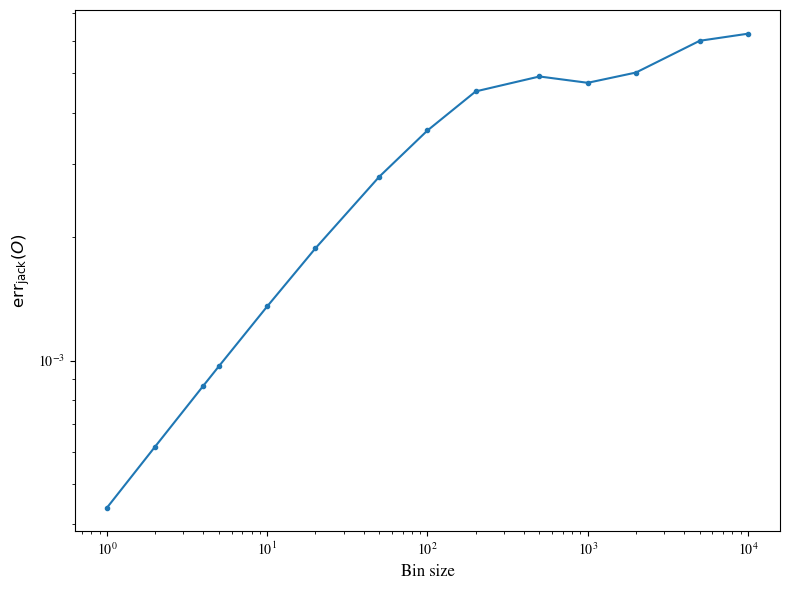

In [3]:
x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, np.array(error_jac), marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size', fontsize=12)
plt.ylabel('${\\rm err}_{\\rm jack}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

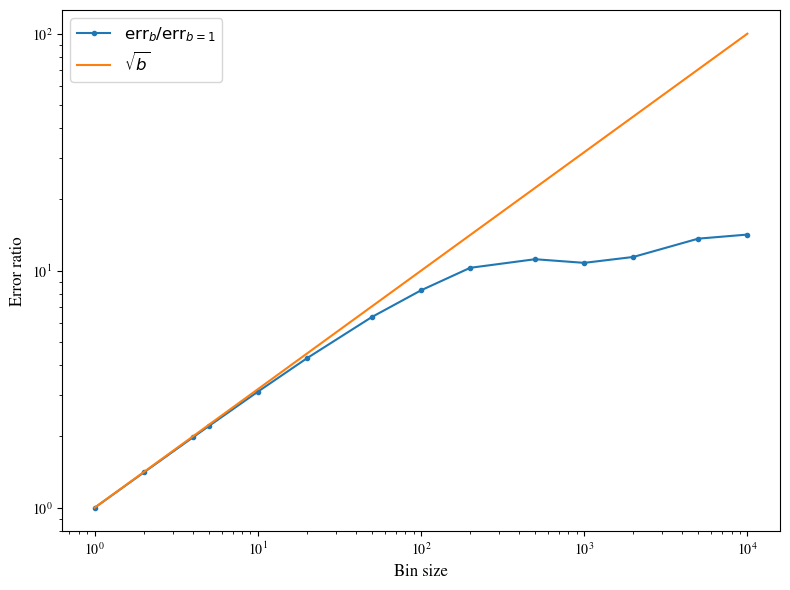

In [57]:
x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], marker='.', linestyle='-', label='${\\rm err}_{b}/{\\rm err}_{b=1}$')
plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{b}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size', fontsize=12)
plt.ylabel('Error ratio', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

# Fig U(1)

In [27]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(self.volume, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        #x= jnp.sin(x)
        x = jnp.ravel(jnp.sin(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        x1 = MLP(self.volume, self.features)(x)
        #x2 = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

## A=4 (l3, w32)

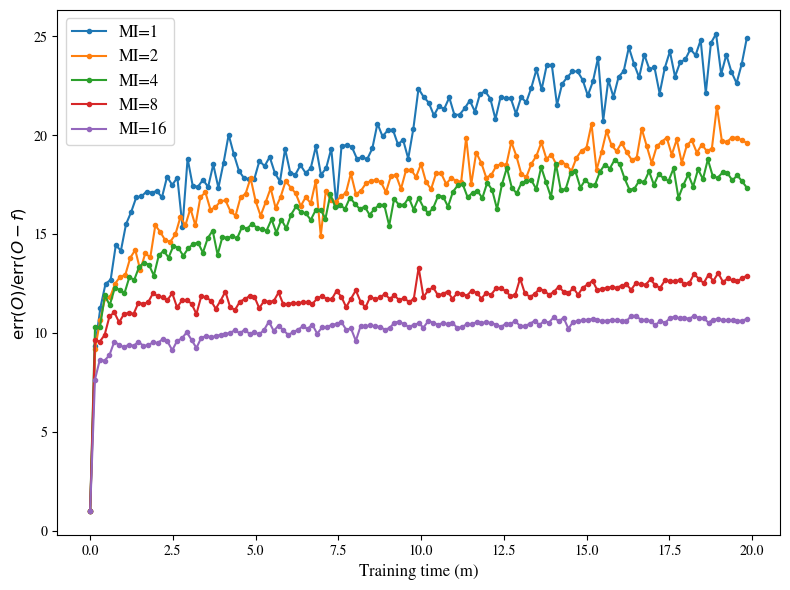

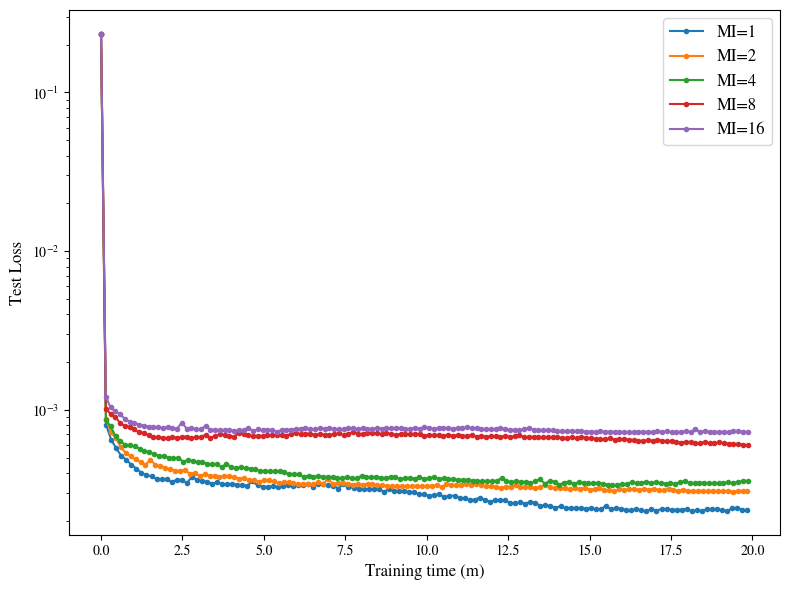

1: 25.124863363171038
2: 21.455245364310127
4: 18.783535335328594
8: 13.322408883186853
16: 10.88950112171693
1: 0.0002289044641656801
2: 0.00030561938183382154
4: 0.00033526733750477433
8: 0.0005982014117762446
16: 0.0007222344866022468


In [58]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*20, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'MI={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*20, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'MI={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## A=16 (l2, w16)

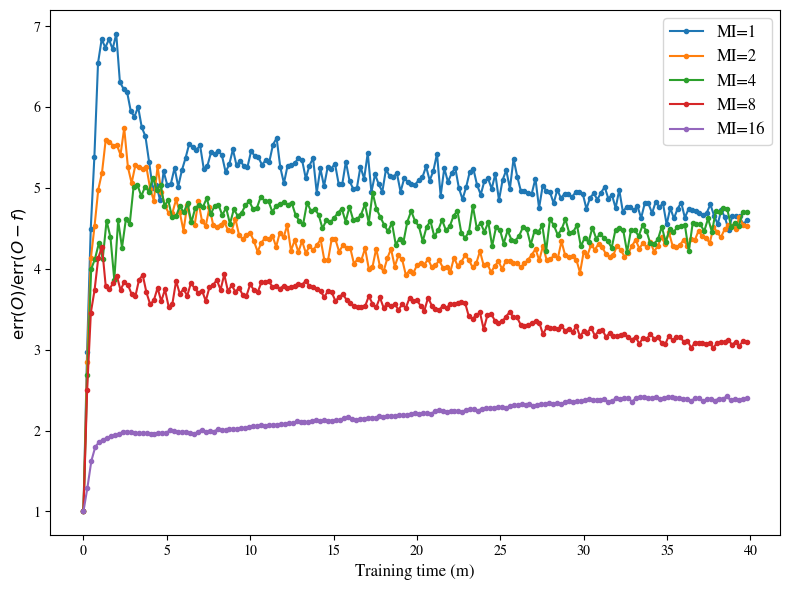

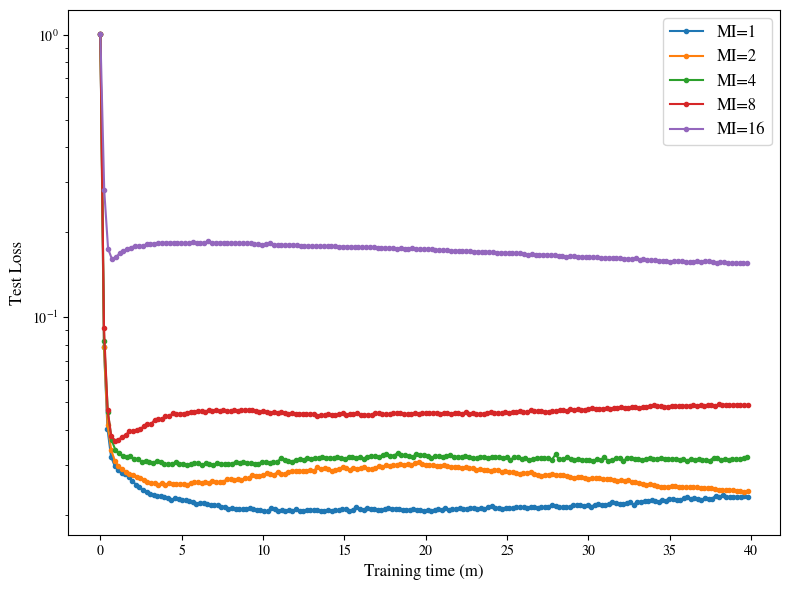

1: 6.906579468502801
2: 5.740324583458335
4: 5.129696798144862
8: 4.27328805661899
16: 2.422392380254361
1: 0.020523278042674065
2: 0.024045681580901146
4: 0.029868612065911293
8: 0.03658305108547211
16: 0.15502721071243286


In [59]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*40, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'MI={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*40, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'MI={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

# scalar field

## 2D 16x16, l2,w16

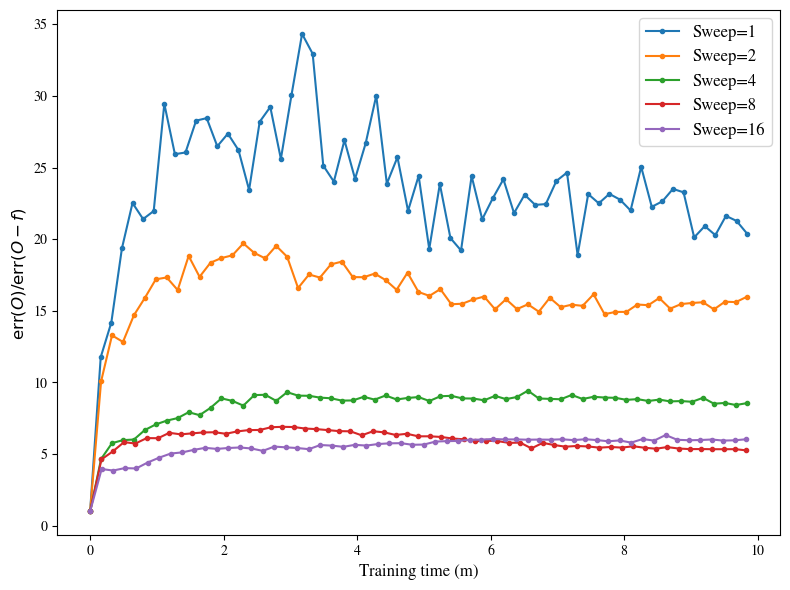

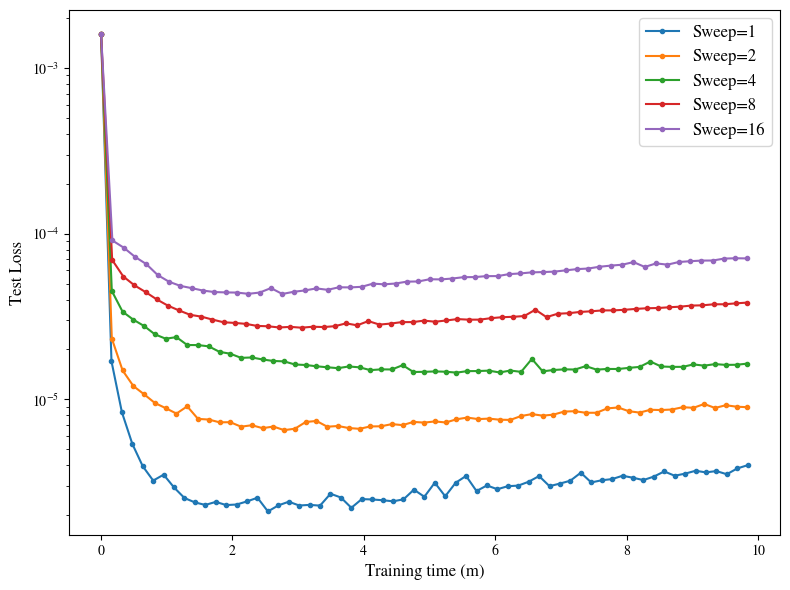

1: (34.3240819294631+0j)
2: (19.705244743080645+0j)
4: (9.429180145968058+0j)
8: (6.905078976815836+0j)
16: (6.332729807327411+0j)
1: 2.1077521523693576e-06
2: 6.522116564156022e-06
4: 1.4499386452371255e-05
8: 2.7063109882874414e-05
16: 4.3229640141362324e-05


In [60]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*10, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Sweep={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*10, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Sweep={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 3D, 32x8x8

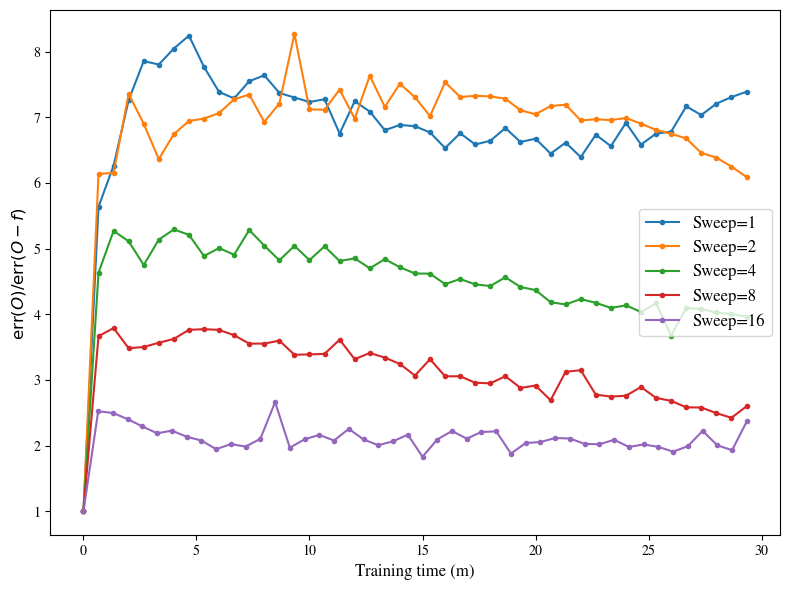

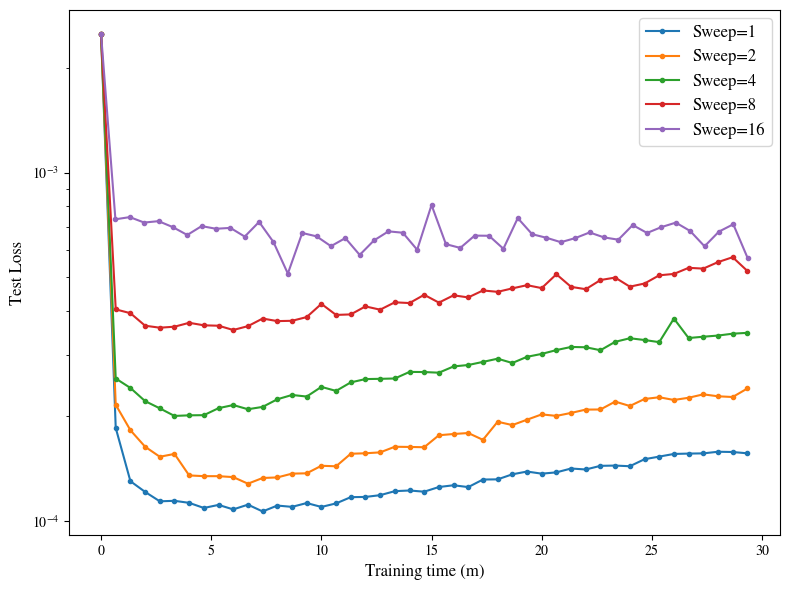

1: (8.244107149580337+0j)
2: (8.270930949376027+0j)
4: (5.2940578303672305+0j)
8: (3.7922831200741927+0j)
16: (2.665026837314087+0j)
1: 0.00010631282202666625
2: 0.00012775893264915794
4: 0.0001999982341658324
8: 0.00035321706673130393
16: 0.000512978935148567


In [61]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*30, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Sweep={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*30, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Sweep={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

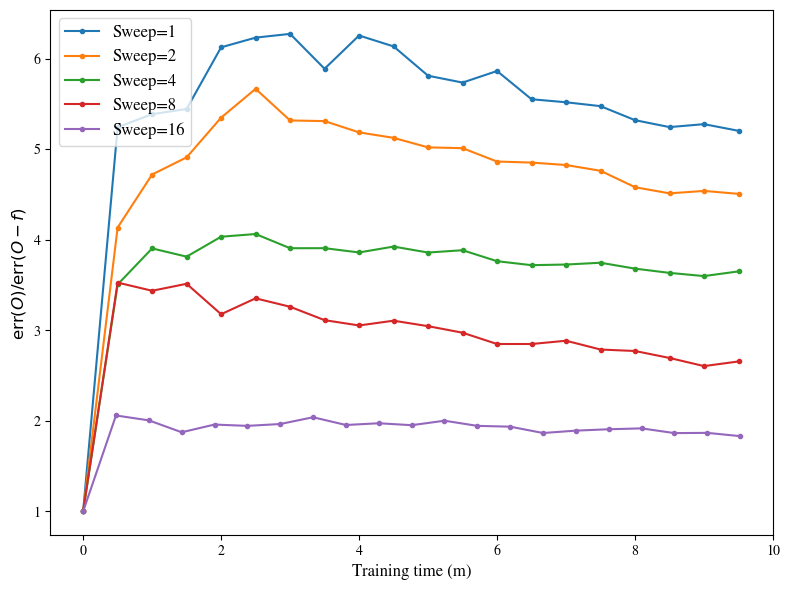

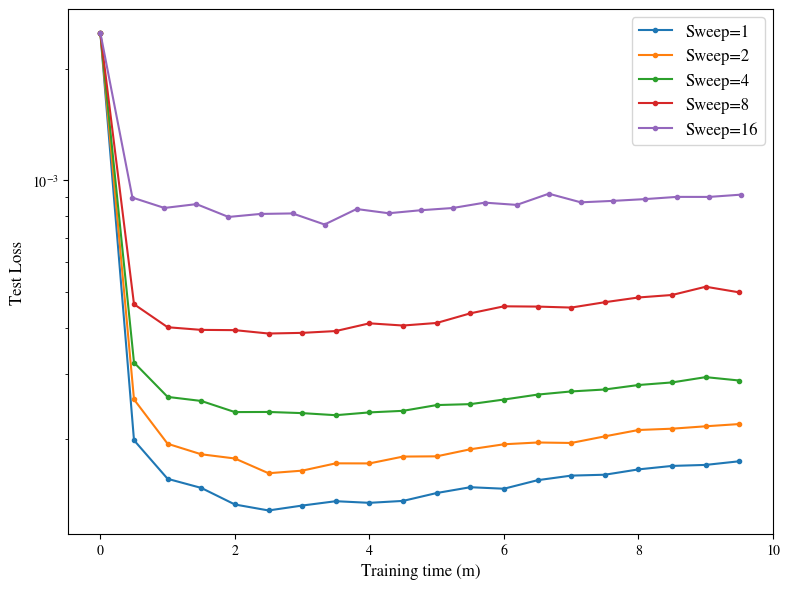

1: (6.274183320684425+0j)
2: (5.6672207519319+0j)
4: (4.063797222752127+0j)
8: (3.527593326798778+0j)
16: (2.059858192867392+0j)
1: 0.00012801312550436705
2: 0.00016140977095346898
4: 0.00023167225299403071
8: 0.0003852873924188316
16: 0.0007596660288982093


In [62]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*10, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Sweep={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*10, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Sweep={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 4D

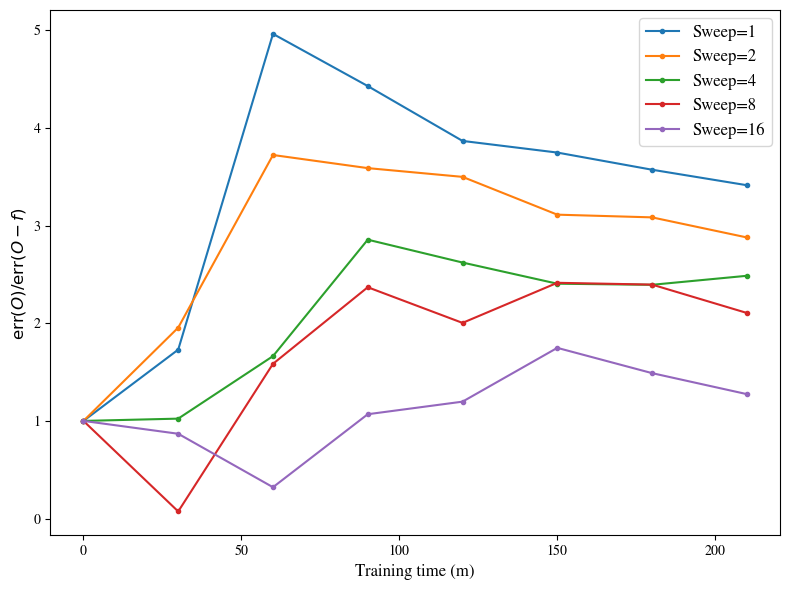

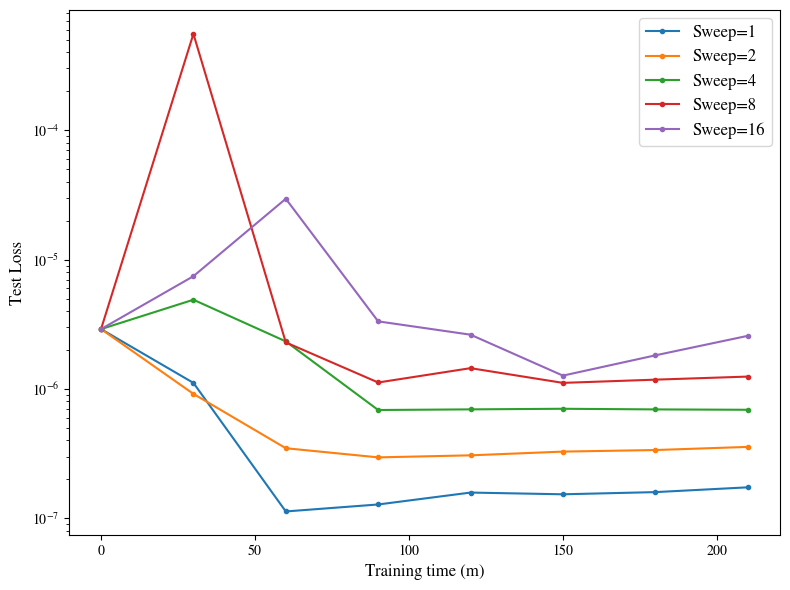

1: (4.962025895341692+0j)
2: (3.7221234500050286+0j)
4: (2.85526632381374+0j)
8: (2.4138193789261853+0j)
16: (1.7477883742165221+0j)
1: 1.1301762015136774e-07
2: 2.959196194751712e-07
4: 6.875184226373676e-07
8: 1.1142010407638736e-06
16: 1.2679042811214458e-06


In [63]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*240, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Sweep={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*240, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Sweep={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")